In [1]:
pip install imbalanced-learn scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from rpy2 import robjects as ro
from rpy2.robjects import pandas2ri

In [3]:
# Read in Elsie's new dataset 
df_new = pd.read_csv("df_1")

In [4]:
# Assuming df_1 is your DataFrame and usefulfeature contains the feature names
usefulfeature = ['BRAND', 'DEPT', 'CITY', 'STATE', 'COUNTY',
                'BRAND_dummy', 'BRAND_dummy_Cheap', 'BRAND_dummy_Affordable',
                'BRAND_dummy_Luxury', 'Returns', 'Salemonth', 'amt_diff',
                'retail_diff']

## Final Feature Engineering 

In [5]:
# Convert 'State' into dummy variables
df_dummies = pd.get_dummies(df_new['STATE'])


## Selecting a Random Subset of the Data

In [6]:
df_new.shape

(65820533, 23)

In [7]:
df_new[df_new['Returns'] == 1].value_counts().sum()

4967908

In [8]:
df_new.head()

,Unnamed: 0.1,Unnamed: 0,SKU,STYPE,STORE,ORGPRICE,QUANTITY,SALEDATE,AMT,BRAND,...,STATE,COUNTY,BRAND_dummy,BRAND_dummy_Cheap,BRAND_dummy_Affordable,BRAND_dummy_Luxury,Returns,Salemonth,amt_diff,retail_diff
0,0,0,3,P,202,30.0,1,2005-01-18,0.0,TURNBURY,...,FL,Hillsborough County,Affordable,0,1,0,0,January,-30.0,410.0
1,1,1,3,R,202,30.0,1,2005-01-29,0.0,TURNBURY,...,FL,Hillsborough County,Affordable,0,1,0,1,January,-30.0,410.0
2,2,2,450,P,202,6.0,1,2005-07-10,6.0,INTERNAT,...,FL,Hillsborough County,Cheap,1,0,0,0,July,0.0,-3.0
3,3,3,450,P,202,6.0,1,2005-06-06,6.0,INTERNAT,...,FL,Hillsborough County,Cheap,1,0,0,0,June,0.0,-3.0
4,4,4,450,P,202,6.0,1,2005-07-29,6.0,INTERNAT,...,FL,Hillsborough County,Cheap,1,0,0,0,July,0.0,-3.0


In [9]:
df_new.isna().sum()

Unnamed: 0.1              0
Unnamed: 0                0
SKU                       0
STYPE                     0
STORE                     0
ORGPRICE                  0
QUANTITY                  0
SALEDATE                  0
AMT                       0
BRAND                     0
DEPT                      0
RETAIL                    0
CITY                      0
STATE                     0
COUNTY                    0
BRAND_dummy               0
BRAND_dummy_Cheap         0
BRAND_dummy_Affordable    0
BRAND_dummy_Luxury        0
Returns                   0
Salemonth                 0
amt_diff                  0
retail_diff               0
dtype: int64

In [10]:
# Drop uneccessary columns 
# Assuming df is your DataFrame and columns_to_drop is a list of column names to be dropped
columns_to_drop = ['Unnamed: 0.1', 'Unnamed: 0']

# Drop the specified columns
df_new = df_new.drop(columns=columns_to_drop, inplace=False)

In [11]:
# Convert 'saledate' to datetime format if it's not already
df_new['SALEDATE'] = pd.to_datetime(df_new['SALEDATE'])

# Extract year from 'saledate'
df_new['year'] = df_new['SALEDATE'].dt.year

# Calculate the range and total number of days for each year
result = df_new.groupby('year')['SALEDATE'].agg(['min', 'max', 'nunique'])

# Display the result
print(result)

            min        max  nunique
year                               
2004 2004-08-01 2004-12-31      151
2005 2005-01-01 2005-08-27      238


Based on the result we want to keep one year worth of data from 2004-08-01 to 2005-08-01

In [12]:
# Before I drop values I concatenate the dummy variables with the original DataFrame
df_new = pd.concat([df_new, df_dummies], axis=1)

start_date = '2004-08-01'
end_date = '2005-08-01'
time_based_subset = df_new[(df_new['SALEDATE'] >= start_date) & (df_new['SALEDATE'] <= end_date)]

In [13]:
# Before we took a subset we had 65820533 obs now 58743194 = 7077339
time_based_subset.shape

(58743194, 51)

In [14]:
def month_name_to_number(month_name):
    month_dict = {
        'January': 1, 'February': 2, 'March': 3, 'April': 4, 'May': 5, 'June': 6,
        'July': 7, 'August': 8, 'September': 9, 'October': 10, 'November': 11, 'December': 12
    }
    return month_dict.get(month_name)

# Apply the custom function to the 'Salemonth' column
time_based_subset['Salemonth'] = time_based_subset['Salemonth'].apply(month_name_to_number)


/var/folders/48/hmcrzlgx0pd5b5ct_wm842_00000gn/T/ipykernel_868/2973287997.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  time_based_subset['Salemonth'] = time_based_subset['Salemonth'].apply(month_name_to_number)


In [15]:
# Check to see that the sales months were correctly applied 
total_unique_months = time_based_subset['Salemonth'].nunique()

print(f'Total unique months: {total_unique_months}')


Total unique months: 12


In [16]:
# Specify columns to convert to categorical
convert_to_factor = ['Salemonth', 'STORE','COUNTY']

# Convert selected columns to categorical
time_based_subset[convert_to_factor] = time_based_subset[convert_to_factor].astype('category')


/var/folders/48/hmcrzlgx0pd5b5ct_wm842_00000gn/T/ipykernel_868/2555102322.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  time_based_subset[convert_to_factor] = time_based_subset[convert_to_factor].astype('category')


## Treat the State Dummy variables

In [17]:
# Find the for the average return rate in total
total_returns = time_based_subset['Returns'].sum()
total_observations = len(time_based_subset)
total_percentage_returns = (total_returns / total_observations) * 100
print(f'Percentage of returns for all states: {total_percentage_returns:.2f}%')

Percentage of returns for all states: 7.53%


In [18]:
time_based_subset['STATE'].head(10)

0    FL
1    FL
2    FL
3    FL
4    FL
5    FL
6    FL
7    FL
8    FL
9    FL
Name: STATE, dtype: object

In [19]:
# Calculate the mean of 'Returns' for each state
StateReturnRate = time_based_subset.groupby('STATE')['Returns'].mean().reset_index()

In [20]:
# Merge the binary column back into the original DataFrame
time_based_subset = pd.merge(time_based_subset, StateReturnRate[['STATE', 'Returns']], on='STATE', how='left')

In [21]:
time_based_subset.rename(columns={'Returns_y': 'ReturnRate'}, inplace=True)
time_based_subset.rename(columns={'Returns_x': 'Returns'}, inplace=True)

In [22]:
time_based_subset.columns

Index(['SKU', 'STYPE', 'STORE', 'ORGPRICE', 'QUANTITY', 'SALEDATE', 'AMT',
       'BRAND', 'DEPT', 'RETAIL', 'CITY', 'STATE', 'COUNTY', 'BRAND_dummy',
       'BRAND_dummy_Cheap', 'BRAND_dummy_Affordable', 'BRAND_dummy_Luxury',
       'Returns', 'Salemonth', 'amt_diff', 'retail_diff', 'year', 'AL', 'AR',
       'AZ', 'CA', 'CO', 'FL', 'GA', 'IA', 'ID', 'IL', 'IN', 'KS', 'KY', 'LA',
       'MO', 'MS', 'MT', 'NC', 'NE', 'NM', 'NV', 'OH', 'OK', 'SC', 'TN', 'TX',
       'UT', 'VA', 'WY', 'ReturnRate'],
      dtype='object')

In [23]:
time_based_subset.head()

,SKU,STYPE,STORE,ORGPRICE,QUANTITY,SALEDATE,AMT,BRAND,DEPT,RETAIL,...,NV,OH,OK,SC,TN,TX,UT,VA,WY,ReturnRate
0,3,P,202,30.0,1,2005-01-18,0.0,TURNBURY,6505,440.0,...,0,0,0,0,0,0,0,0,0,0.075151
1,3,R,202,30.0,1,2005-01-29,0.0,TURNBURY,6505,440.0,...,0,0,0,0,0,0,0,0,0,0.075151
2,450,P,202,6.0,1,2005-07-10,6.0,INTERNAT,1202,3.0,...,0,0,0,0,0,0,0,0,0,0.075151
3,450,P,202,6.0,1,2005-06-06,6.0,INTERNAT,1202,3.0,...,0,0,0,0,0,0,0,0,0,0.075151
4,450,P,202,6.0,1,2005-07-29,6.0,INTERNAT,1202,3.0,...,0,0,0,0,0,0,0,0,0,0.075151


# Balancing Data 

In [24]:
pip install imbalanced-learn

Note: you may need to restart the kernel to use updated packages.


In [25]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from collections import Counter
import pickle

In [26]:
time_based_subset.head()

,SKU,STYPE,STORE,ORGPRICE,QUANTITY,SALEDATE,AMT,BRAND,DEPT,RETAIL,...,NV,OH,OK,SC,TN,TX,UT,VA,WY,ReturnRate
0,3,P,202,30.0,1,2005-01-18,0.0,TURNBURY,6505,440.0,...,0,0,0,0,0,0,0,0,0,0.075151
1,3,R,202,30.0,1,2005-01-29,0.0,TURNBURY,6505,440.0,...,0,0,0,0,0,0,0,0,0,0.075151
2,450,P,202,6.0,1,2005-07-10,6.0,INTERNAT,1202,3.0,...,0,0,0,0,0,0,0,0,0,0.075151
3,450,P,202,6.0,1,2005-06-06,6.0,INTERNAT,1202,3.0,...,0,0,0,0,0,0,0,0,0,0.075151
4,450,P,202,6.0,1,2005-07-29,6.0,INTERNAT,1202,3.0,...,0,0,0,0,0,0,0,0,0,0.075151


In [27]:
final_features = ['Salemonth', 'ORGPRICE', 'AMT',
                'amt_diff', 'retail_diff', 'BRAND_dummy_Affordable','BRAND_dummy_Luxury', 
                 'ReturnRate', 'Returns']

In [28]:
df_final = time_based_subset[final_features].copy()

In [29]:
df_final.head()

,Salemonth,ORGPRICE,AMT,amt_diff,retail_diff,BRAND_dummy_Affordable,BRAND_dummy_Luxury,ReturnRate,Returns
0,1,30.0,0.0,-30.0,410.0,1,0,0.075151,0
1,1,30.0,0.0,-30.0,410.0,1,0,0.075151,1
2,7,6.0,6.0,0.0,-3.0,0,0,0.075151,0
3,6,6.0,6.0,0.0,-3.0,0,0,0.075151,0
4,7,6.0,6.0,0.0,-3.0,0,0,0.075151,0


In [30]:
df_final.dtypes

Salemonth                 category
ORGPRICE                   float64
AMT                        float64
amt_diff                   float64
retail_diff                float64
BRAND_dummy_Affordable       int64
BRAND_dummy_Luxury           int64
ReturnRate                 float64
Returns                      int64
dtype: object

In [31]:
df_final.columns

Index(['Salemonth', 'ORGPRICE', 'AMT', 'amt_diff', 'retail_diff',
       'BRAND_dummy_Affordable', 'BRAND_dummy_Luxury', 'ReturnRate',
       'Returns'],
      dtype='object')

In [32]:
# Pick a random subset of 100k
subset_size = 100000

# Use the sample method to get a random subset
random_subset = df_final.sample(n=subset_size, random_state=42)  # Setting a random seed for reproducibility

# Print or further process the random subset
print(random_subset)

         Salemonth  ORGPRICE     AMT  amt_diff  retail_diff  \
52416796         7     27.99   27.99       0.0       -14.00   
8737932         12     20.00   20.00       0.0         0.00   
50204438         5      7.00    7.00       0.0         0.00   
38732071        10     22.50   21.00      -1.5         0.00   
24250497        10     50.50   22.00     -28.5       -27.50   
...            ...       ...     ...       ...          ...   
13101276         5     30.00   30.00       0.0       -15.00   
35736111        10     18.00   14.00      -4.0       -11.00   
342172           5    138.00  138.00       0.0      -103.50   
21186853         7     58.00   56.00      -2.0       -30.00   
51507379         7    179.00  179.00       0.0      -139.01   

          BRAND_dummy_Affordable  BRAND_dummy_Luxury  ReturnRate  Returns  
52416796                       1                   0    0.063171        0  
8737932                        1                   0    0.065060        0  
50204438       

In [33]:
# Split the dataset into 80% training and 20% testing
train_set, test_set = train_test_split(random_subset, test_size=0.2, random_state=42)

In [34]:
# Separate features (X) and target variable (y)
X_test = test_set.drop('Returns', axis=1)
y_test = test_set['Returns']

In [35]:
# From the train set keep all the Returns 
train_set_return=train_set[train_set['Returns']==1]

In [36]:
# Filter the training set where Returns is 0
subset_puchases = train_set.query('Returns == 0')

# Randomly select 15,000 observations from the subset 
train_set_purchase = subset_puchases.sample(n=15000, random_state=42)

In [37]:
train_set_return.shape

(5983, 9)

In [38]:
train_set_purchase.shape

(15000, 9)

In [39]:
# Concatenate vertically (stacking rows)
train_set_combined = pd.concat([train_set_return, train_set_purchase], axis=0, ignore_index=True)

In [40]:
# Separate features (X) and target variable (y)
X_train = train_set_combined.drop('Returns', axis=1)
y_train = train_set_combined['Returns']

In [41]:
random_subset.dtypes

Salemonth                 category
ORGPRICE                   float64
AMT                        float64
amt_diff                   float64
retail_diff                float64
BRAND_dummy_Affordable       int64
BRAND_dummy_Luxury           int64
ReturnRate                 float64
Returns                      int64
dtype: object

In [42]:
X_train

,Salemonth,ORGPRICE,AMT,amt_diff,retail_diff,BRAND_dummy_Affordable,BRAND_dummy_Luxury,ReturnRate
0,7,79.50,79.50,0.00,-39.75,0,1,0.081596
1,1,18.75,12.50,-6.25,-6.25,1,0,0.085262
2,8,14.50,14.50,0.00,0.00,0,0,0.084576
3,2,34.00,34.00,0.00,-24.01,1,0,0.073191
4,2,22.00,20.00,-2.00,-2.00,1,0,0.073191
...,...,...,...,...,...,...,...,...
20978,11,19.50,18.50,-1.00,-1.00,1,0,0.074856
20979,9,110.25,60.00,-50.25,-95.25,0,1,0.073191
20980,12,10.99,10.99,0.00,-5.49,0,0,0.081942
20981,5,39.00,39.00,0.00,-19.50,1,0,0.084399


In [43]:
y_train.isnull().any()

False

In [44]:
# Instantiate the SMOTE algorithm
smote = SMOTE(random_state=42)

# Apply SMOTE to balance the classes
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# Create a new DataFrame with the resampled data
resampled_df = pd.concat([pd.DataFrame(X_resampled, columns=X_train.columns), pd.Series(y_resampled, name='return')], axis=1)


In [45]:
print("Before SMOTE:", Counter(y_train))
print("After SMOTE:", Counter(y_resampled))

Before SMOTE: Counter({0: 15000, 1: 5983})
After SMOTE: Counter({1: 15000, 0: 15000})


In [46]:
#Generate random indices for missing values
missing_indices = X_resampled[X_resampled['Salemonth'].isnull()].index

In [47]:
# Replace missing values with random samples from observed values
X_resampled.loc[missing_indices, 'Salemonth'] = np.random.choice(X_resampled['Salemonth'].dropna(), size=len(missing_indices))

# Verify that missing values have been imputed
print(X_resampled['Salemonth'].isnull().sum())

0


In [48]:
resampled_df.to_pickle('df_train_resampled.pkl')
test_set.to_pickle('df_test.pkl')

In [49]:
df_final.to_pickle('df_final.pkl')

In [50]:
random_subset.to_pickle('data_subset.plk')

# MODELING - Logistic Regression 

In [51]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import make_classification
import statsmodels.api as sm
from sklearn.metrics import roc_curve, auc

In [52]:
# Check if every column has all NaN values
nan_check_all = resampled_df.isnull().all()

# Display the result
print("Columns with all NaN values:")
print(nan_check_all)

Columns with all NaN values:
Salemonth                 False
ORGPRICE                  False
AMT                       False
amt_diff                  False
retail_diff               False
BRAND_dummy_Affordable    False
BRAND_dummy_Luxury        False
ReturnRate                False
return                    False
dtype: bool


In [53]:
resampled_df.dtypes

Salemonth                 category
ORGPRICE                   float64
AMT                        float64
amt_diff                   float64
retail_diff                float64
BRAND_dummy_Affordable       int64
BRAND_dummy_Luxury           int64
ReturnRate                 float64
return                       int64
dtype: object

In [54]:
# Check if any value is of type str in the entire DataFrame
any(resampled_df.applymap(lambda x: isinstance(x, str)).any())

False

In [55]:
# Check if any column contains strings
contains_strings = any(resampled_df.applymap(lambda x: isinstance(x, str)).any())

# Check for infinite values (excluding categorical columns)
contains_infinite = any(resampled_df.select_dtypes(exclude='category').applymap(np.isfinite).any())

print("Contains Strings:", contains_strings)
print("Contains Infinite Values:", contains_infinite)

Contains Strings: False
Contains Infinite Values: True


In [56]:
# Check for infinite values in each column and count them
infinite_counts = resampled_df.replace([np.inf, -np.inf], np.nan).isna().sum()

# Identify columns with infinite values
columns_with_infinite = infinite_counts[infinite_counts > 0].index.tolist()

# Display the result
print("Columns with Infinite Values:", columns_with_infinite)
print("Infinite Value Counts per Column:")
print(infinite_counts[columns_with_infinite])

Columns with Infinite Values: ['Salemonth']
Infinite Value Counts per Column:
Salemonth    4070
dtype: int64


In [57]:
train_set.describe()

,ORGPRICE,AMT,amt_diff,retail_diff,BRAND_dummy_Affordable,BRAND_dummy_Luxury,ReturnRate,Returns
count,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000
mean,38.304703,33.922430,-4.382274,-17.824567,0.507350,0.236512,0.075265,0.074788
std,39.737948,39.018835,16.654408,26.850537,0.499949,0.424943,0.005252,0.263050
min,0.000000,0.000000,-648.400000,-745.150000,0.000000,0.000000,0.059142,0.000000
25%,17.500000,14.000000,-2.250000,-25.500000,0.000000,0.000000,0.073191,0.000000
50%,28.000000,24.000000,0.000000,-10.000000,1.000000,0.000000,0.075151,0.000000
75%,49.000000,44.000000,0.000000,0.000000,1.000000,0.000000,0.078173,0.000000
max,895.000000,895.000000,326.700000,278.000000,1.000000,1.000000,0.085262,1.000000


In [117]:
corr_matrix = resampled_df.corr()
# Display the correlation matrix
print("Correlation Matrix:")
print(corr_matrix)

Correlation Matrix:
                        ORGPRICE       AMT  amt_diff  retail_diff  \
ORGPRICE                1.000000  0.902663 -0.276707    -0.765916   
AMT                     0.902663  1.000000  0.163772    -0.585757   
amt_diff               -0.276707  0.163772  1.000000     0.447751   
retail_diff            -0.765916 -0.585757  0.447751     1.000000   
BRAND_dummy_Affordable -0.276455 -0.241279  0.094954     0.245562   
BRAND_dummy_Luxury      0.652106  0.598518 -0.158368    -0.537571   
ReturnRate              0.033035  0.030433 -0.007772    -0.063688   
return                  0.115488  0.134081  0.034663    -0.094381   

                        BRAND_dummy_Affordable  BRAND_dummy_Luxury  \
ORGPRICE                             -0.276455            0.652106   
AMT                                  -0.241279            0.598518   
amt_diff                              0.094954           -0.158368   
retail_diff                           0.245562           -0.537571   
BRAND_du

/var/folders/48/hmcrzlgx0pd5b5ct_wm842_00000gn/T/ipykernel_868/3471047481.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = resampled_df.corr()


In [59]:
# Check for zero variance columns 
zero_var_columns = resampled_df.columns[random_subset.nunique() == 1]
print("Columns with zero variance:", zero_var_columns)

Columns with zero variance: Index([], dtype='object')


In [60]:
X_resampled.isna().sum()

Salemonth                 0
ORGPRICE                  0
AMT                       0
amt_diff                  0
retail_diff               0
BRAND_dummy_Affordable    0
BRAND_dummy_Luxury        0
ReturnRate                0
dtype: int64

In [61]:
mymodel=LogisticRegression()
mymodel.fit(X_resampled,y_resampled)

# Display the summary
print("Intercept:", mymodel.intercept_)
print('Coefficients:', mymodel.coef_)

Intercept: [-0.54712508]
Coefficients: [[ 0.00129669 -0.00186754  0.00441286  0.0062804  -0.00467846  0.45084869
   0.55886618 -0.0315654 ]]


In [64]:
# Make predictions on the resampled test data
predict1 = mymodel.predict(X_test)

# Evaluate the model on the resampled training data
accuracy_resampled = accuracy_score(y_test, predict1)
conf_matrix_resampled = confusion_matrix(y_test, predict1)
classification_rep_resampled = classification_report(y_test, predict1)

# Print the evaluation metrics on the resampled training data
print("Accuracy on Test Data:", accuracy_resampled)
print("Confusion Matrix on Test Data:\n", conf_matrix_resampled)
print("Classification Report on Test Data:\n", classification_rep_resampled)

Accuracy on Test Data: 0.55715
Confusion Matrix on Test Data:
 [[10151  8286]
 [  571   992]]
Classification Report on Test Data:
               precision    recall  f1-score   support

           0       0.95      0.55      0.70     18437
           1       0.11      0.63      0.18      1563

    accuracy                           0.56     20000
   macro avg       0.53      0.59      0.44     20000
weighted avg       0.88      0.56      0.66     20000



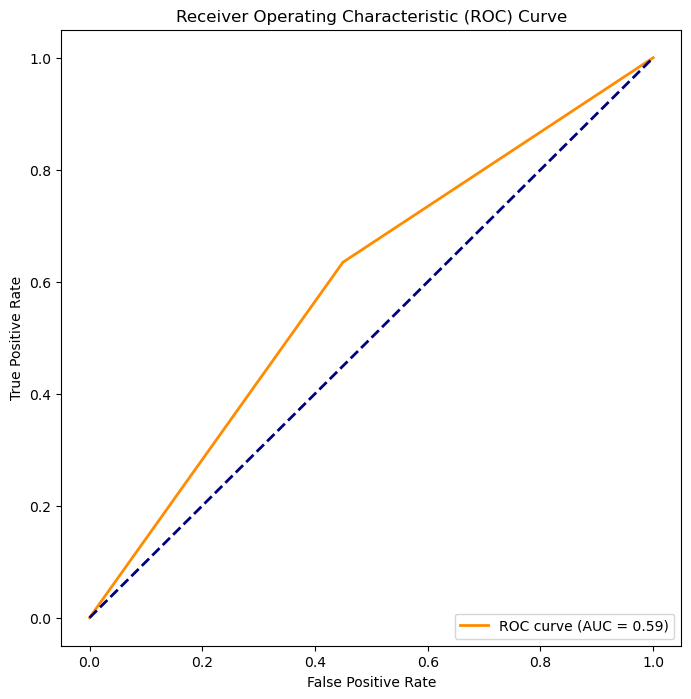

In [65]:
## ROC curve 

# Generate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, predict1)

# Calculate the area under the ROC curve (AUC)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

## Try Using Stats Models

In [73]:
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
import pandas as pd

# Add a constant to the features matrix for statsmodels
model1 = sm.add_constant(X_resampled)

# Create and fit a logistic regression model with statsmodels
logit_model = sm.Logit(y_resampled, X_resampled)
result = logit_model.fit()

# Display the summary
print(result.summary())


         Current function value: 0.679152
         Iterations: 35
                           Logit Regression Results                           
Dep. Variable:                Returns   No. Observations:                30000
Model:                          Logit   Df Residuals:                    29992
Method:                           MLE   Df Model:                            7
Date:                Thu, 07 Dec 2023   Pseudo R-squ.:                 0.02019
Time:                        18:49:23   Log-Likelihood:                -20375.
converged:                      False   LL-Null:                       -20794.
Covariance Type:            nonrobust   LLR p-value:                5.035e-177
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
Salemonth                 -0.0022      0.004     -0.605      0.545      -0.009       0.005
ORGPRICE                  -0.

/Users/xeniavrettakou/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [74]:
p_values = result.pvalues
print("P-values:")
print(p_values)

P-values:
Salemonth                 5.450095e-01
ORGPRICE                  9.999999e-01
AMT                       9.999997e-01
amt_diff                  9.999996e-01
retail_diff               8.664716e-11
BRAND_dummy_Affordable    2.090533e-41
BRAND_dummy_Luxury        3.653781e-30
ReturnRate                3.600921e-48
dtype: float64


## Model Improvement 

In [84]:
X_resampled.columns

Index(['Salemonth', 'ORGPRICE', 'AMT', 'amt_diff', 'retail_diff',
       'BRAND_dummy_Affordable', 'BRAND_dummy_Luxury', 'ReturnRate'],
      dtype='object')

In [89]:
drop2 = ['AMT','amt_diff']

# Drop the specified columns
X_resampled_reduced = X_resampled.drop(columns=drop2, inplace=False)

# Add a constant to the features matrix for statsmodels
x_with_const = sm.add_constant(X_resampled_reduced)

# Create and fit a logistic regression model with statsmodels
logit_model = sm.Logit(y_resampled, X_resampled_reduced)
result = logit_model.fit()

# Display the summary
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.682104
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:                Returns   No. Observations:                30000
Model:                          Logit   Df Residuals:                    29994
Method:                           MLE   Df Model:                            5
Date:                Thu, 07 Dec 2023   Pseudo R-squ.:                 0.01593
Time:                        18:51:43   Log-Likelihood:                -20463.
converged:                       True   LL-Null:                       -20794.
Covariance Type:            nonrobust   LLR p-value:                5.942e-141
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
Salemonth                 -0.0055      0.004     -1.527      0.127      -0.012      

In [113]:
drop3 = ['AMT','amt_diff','retail_diff']

# Drop the specified columns
X_resampled_reduced3 = X_resampled.drop(columns=drop3, inplace=False)

# Add a constant to the features matrix for statsmodels
x_with_const3 = sm.add_constant(X_resampled_reduced3)

# Create and fit a logistic regression model with statsmodels
logit_model3 = sm.Logit(y_resampled, X_resampled_reduced3)
result3 = logit_model3.fit()

# Display the summary
print(result3.summary())

Optimization terminated successfully.
         Current function value: 0.682131
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:                Returns   No. Observations:                30000
Model:                          Logit   Df Residuals:                    29995
Method:                           MLE   Df Model:                            4
Date:                Thu, 07 Dec 2023   Pseudo R-squ.:                 0.01589
Time:                        22:08:36   Log-Likelihood:                -20464.
converged:                       True   LL-Null:                       -20794.
Covariance Type:            nonrobust   LLR p-value:                9.816e-142
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
Salemonth                 -0.0059      0.004     -1.664      0.096      -0.013      

## Replicate in SKLearn

In [111]:
# Drop specified columns
drop3 = ['AMT', 'amt_diff', 'retail_diff']

X_resampled_reduced3 = X_resampled.drop(columns=drop3, inplace=False)
X_test_reduced = X_test.drop(columns=drop3, inplace=False)

# Create and fit a logistic regression model with scikit-learn
final_fit = LogisticRegression()
final_fit.fit(X_resampled_reduced3, y_resampled)

# Display the coefficients and intercept
print("Coefficients:", final_fit.coef_)
print("Intercept:", final_fit.intercept_)

# Display the summary (optional, not as detailed as statsmodels summary)
print("Model Summary:")
print("Accuracy on training set:", final_fit.score(X_resampled_reduced3, y_resampled))
print("Accuracy on test set:", final_fit.score(X_resampled_reduced3, y_resampled))

# Make predictions on the test set
final_pred = final_fit.predict(X_test_reduced)

# Create a confusion matrix
conf_matrix = confusion_matrix(y_test, final_pred)

# Display the confusion matrix
print("\nConfusion Matrix:")
print(conf_matrix)

# Calculate additional metrics using scikit-learn
print("\nClassification Report:")
print(classification_report(y_test, final_pred))

Coefficients: [[-0.0022784   0.00304754  0.47920028  0.63359769 -0.02940541]]
Intercept: [-0.53280026]
Model Summary:
Accuracy on training set: 0.5677666666666666
Accuracy on test set: 0.5677666666666666

Confusion Matrix:
[[ 7803 10634]
 [  415  1148]]

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.42      0.59     18437
           1       0.10      0.73      0.17      1563

    accuracy                           0.45     20000
   macro avg       0.52      0.58      0.38     20000
weighted avg       0.88      0.45      0.55     20000

